In [1]:
import pandas as pd
from bs4 import BeautifulSoup
import xml
import numpy as np
from sklearn.model_selection import train_test_split
import re

In [2]:
ss=df=pd.read_csv('train_set.csv')
test=pd.read_csv('test_data.csv')

In [3]:
f=open('test.html','w')

In [4]:
def replace_repeating_newlines(df):
    # Replace all repeating newlines with a single newline in the Text column
    df['Text'] = df['Text'].str.replace('\n+', '\n')

    # Replace all repeating newlines with a single newline in the Titles column
    df['Titles'] = df['Titles'].str.replace('\n+', '\n')

    # Replace all repeating newlines with a single newline in the Links column
    df['Links'] = df['Links'].str.replace('\n+', '\n')

    return df

In [5]:
url_pattern = re.compile(r'https?://[^\s]+.com')
def ret_info(df):
    links=[]
    titles=[]
    text=[]
    for i in range(len(df)):
        h=df.Html.loc[i].strip().lower()
        soup=BeautifulSoup(h,'html.parser')
        script_tags = soup.find_all("script")
        p_tags = soup.find_all("p")
        hreftags= soup.find_all('link')
        script_contents = [script.string for script in script_tags if script.string]
        http_links_in_scripts = [url_pattern.findall(script) for script in script_contents]
        http_links_in_scripts = [url for sublist in http_links_in_scripts for url in sublist]
        https_links = [link["href"] for link in hreftags if link.has_attr("href") and link["href"].startswith("https://")]
        if(http_links_in_scripts==None and https_links==None):
            links.append('')
        links.append(set(http_links_in_scripts+https_links))
        if soup.title!=None:
            titles.append(soup.text.strip())
        else:
            titles.append('')
        text.append([p.text.strip() for p in p_tags])
    for i in range(len(text)):
        text[i]='\n'.join(text[i])
        links[i]='\n'.join(links[i])
    return (links,text,titles)
def find(ass,x):
    for line in ass:
        if line.find(x)!=-1:
            return True
    return False
def Checker(df,links,text,titles):
    a=0
    for i in range(len(links)):
            p=df.Source.loc[i].strip().lower()
            h=df.Html.loc[i].strip().lower()    
            if any(p in link for link in links[i] ):
                a+=1
                continue
            for word in p.split():
                if (titles[i]!=None and titles[i].find(word)!=-1):
                    a+=1
                else:
                    if(p.split()==1):
                        continue
                    for word in p.split():
                        if any(word in link for link in links[i] ):
                            a+=1     
                            break  
                        elif (titles[i]!=None and titles[i].find(word)!=-1):
                            a+=1
                            break  
                        elif (text[i]!=None and find(text[i],word)):
                            a+=1
                            break    
    return a

In [6]:
(links,text,titles) = ret_info(df)
(linkst,textt,titlest) = ret_info(test)
df=pd.DataFrame({'Titles':titles,'Links':links,'Text':text})
fd=pd.DataFrame({'Titles':titlest,'Links':linkst,'Text':textt})

In [7]:
a=0
for i in range(len(df)):
    if (df.Text.loc[i]=='' and df.Links.loc[i]=='' and df.Titles.loc[i]==''):
        df=df.drop(i)
        ss=ss.drop(i)
        a+=1
y=ss.Source

In [8]:
df=replace_repeating_newlines(df)
fd=replace_repeating_newlines(fd)

/tmp/ipykernel_4154/3379126514.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Text'] = df['Text'].str.replace('\n+', '\n')
/tmp/ipykernel_4154/3379126514.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Titles'] = df['Titles'].str.replace('\n+', '\n')
/tmp/ipykernel_4154/3379126514.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Links'] = df['Links'].str.replace('\n+', '\n')


In [9]:
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.1, random_state=42)
#X_train, X_test, y_train = df,fd,y

In [10]:
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
import tensorflow_hub as hub
#import tensorflow_text as text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from keras import Model,layers,Input
from keras.layers import Dense,LSTM,RNN,GRU,Add,Dropout
from keras.optimizers import Adam
from keras.layers import Concatenate
from keras.layers import Reshape
from keras.utils import to_categorical
from keras.layers import Flatten
from keras.losses import CategoricalCrossentropy

ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
embed = hub.load('https://tfhub.dev/google/universal-sentence-encoder/4')
def create_embeddings(text):
    input_tensor = tf.convert_to_tensor([text], dtype=tf.string)
    embeddings = embed(input_tensor)[0].numpy()
    return embeddings

2023-04-18 19:20:52.150158: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-18 19:20:52.154871: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-18 19:20:52.155139: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-18 19:20:52.156501: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-18 19:20:52.156856: I tensorflow/compile

In [ ]:
label_encoder = LabelEncoder()
ylabel=label_encoder.fit_transform(y)
ytrain_label=label_encoder.transform(y_train)
#y_test_label=label_encoder.transform(y_test)
y_one_hot = to_categorical(ylabel, num_classes=596)

In [ ]:
X=pd.DataFrame()

In [ ]:

X['Text'] = X_train['Text'].apply(create_embeddings)
X['Links'] = X_train['Links'].apply(create_embeddings)
X['Titles'] = X_train['Titles'].apply(create_embeddings)

2023-04-18 19:20:59.931399: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype string
	 [[{{node inputs}}]]
2023-04-18 19:21:01.656842: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [ ]:
Xtest=pd.DataFrame()
Xtest['Text'] = X_test['Text'].apply(create_embeddings)
Xtest['Links'] = X_test['Links'].apply(create_embeddings)
Xtest['Titles'] = X_test['Titles'].apply(create_embeddings)

In [ ]:

#y_test_hot = to_categorical(y_test_label, num_classes=596)

In [ ]:
tensor_text = tf.stack(X['Text'].tolist())
tensor_links = tf.stack(X['Links'].tolist())
tensor_titles = tf.stack(X['Titles'].tolist())
tensor_textt = tf.stack(Xtest['Text'].tolist())
tensor_linkst = tf.stack(Xtest['Links'].tolist())
tensor_titlest = tf.stack(Xtest['Titles'].tolist())

#y_test_hot = to_categorical(y_test_label, num_classes=596)

In [ ]:
asd

Model_1


In [ ]:
input_text = Input(shape=(512,))
input_links = Input(shape=(512,))
input_titles = Input(shape=(512,))
merged_inputs = Concatenate(axis=1)([input_text, input_links, input_titles])
reshaped_inputs = Reshape((3, 512))(merged_inputs)
x = LSTM(units=64, activation='relu')(reshaped_inputs)
output= Dense(len(y.value_counts()),activation='softmax')(x)
model_1 = Model(inputs=[input_text, input_links, input_titles],outputs=output)
model_1.compile(loss='categorical_crossentropy',optimizer=Adam(),metrics=['accuracy'])
model_1_history = model_1.fit(epochs=10,x=[tensor_text, tensor_links, tensor_titles],y=y_one_hot)
predictions=np.array(model_1.predict([tensor_textt,tensor_linkst,tensor_titlest]))
index = int(tf.argmax(predictions[-4]).numpy())
label_encoder.inverse_transform(np.array([index]))

Epoch 1/10
85/85 [==============================] - 2s 12ms/step - loss: 6.3175 - accuracy: 0.0193
Epoch 2/10
85/85 [==============================] - 1s 11ms/step - loss: 5.9317 - accuracy: 0.0297
Epoch 3/10
85/85 [==============================] - 1s 12ms/step - loss: 5.5897 - accuracy: 0.0505
Epoch 4/10
85/85 [==============================] - 1s 11ms/step - loss: 5.1262 - accuracy: 0.0954
Epoch 5/10
85/85 [==============================] - 1s 11ms/step - loss: 4.7117 - accuracy: 0.1251
Epoch 6/10
85/85 [==============================] - 1s 11ms/step - loss: 4.3025 - accuracy: 0.1779
Epoch 7/10
85/85 [==============================] - 1s 11ms/step - loss: 3.8861 - accuracy: 0.2265
Epoch 8/10
85/85 [==============================] - 1s 11ms/step - loss: 3.4927 - accuracy: 0.2644
Epoch 9/10
85/85 [==============================] - 1s 11ms/step - loss: 3.1309 - accuracy: 0.3115
Epoch 10/10
22/22 [==============================] - 0s 2ms/step


array(['Latino Post'], dtype=object)

Model_2

In [ ]:
input_text = Input(shape=(512,))
input_links = Input(shape=(512,))
input_titles = Input(shape=(512,))
merged_inputs = Concatenate(axis=1)([input_text, input_links, input_titles])
reshaped_inputs = Reshape((3, 512))(merged_inputs)
x = LSTM(units=128, activation='relu')(reshaped_inputs)
x = Dense(64,activation='relu')(x)
output= Dense(len(y.value_counts()),activation='softmax')(x)
model_2 = Model(inputs=[input_text, input_links, input_titles],outputs=output)
model_2.compile(loss='categorical_crossentropy',optimizer=Adam(),metrics=['accuracy'])
model_2_history = model_2.fit(epochs=10,x=[tensor_text, tensor_links, tensor_titles],y=y_one_hot,validation_data=([tensor_textt, tensor_linkst, tensor_titlest],y_test_hot))
predictions=np.array(model_2.predict([tensor_textt,tensor_linkst,tensor_titlest]))
index = int(tf.argmax(predictions[-4]).numpy())
label_encoder.inverse_transform(np.array([index]))

Epoch 1/10
76/76 [==============================] - 2s 14ms/step - loss: 6.3135 - accuracy: 0.0198 - val_loss: 6.1908 - val_accuracy: 0.0111
Epoch 2/10
76/76 [==============================] - 1s 13ms/step - loss: 5.8553 - accuracy: 0.0400 - val_loss: 5.8924 - val_accuracy: 0.0296
Epoch 3/10
76/76 [==============================] - 1s 12ms/step - loss: 5.3759 - accuracy: 0.0586 - val_loss: 5.6556 - val_accuracy: 0.0444
Epoch 4/10
76/76 [==============================] - 1s 13ms/step - loss: 4.9891 - accuracy: 0.0862 - val_loss: 5.4268 - val_accuracy: 0.0926
Epoch 5/10
76/76 [==============================] - 1s 13ms/step - loss: 4.6195 - accuracy: 0.1163 - val_loss: 5.4022 - val_accuracy: 0.1000
Epoch 6/10
76/76 [==============================] - 1s 13ms/step - loss: 4.1992 - accuracy: 0.1596 - val_loss: 5.1589 - val_accuracy: 0.1593
Epoch 7/10
76/76 [==============================] - 1s 13ms/step - loss: 3.7613 - accuracy: 0.2016 - val_loss: 5.1686 - val_accuracy: 0.1741
Epoch 8/10
76

array(['Irish Independent'], dtype=object)

Model_3

In [ ]:
input_text = Input(shape=(512,))
input_links = Input(shape=(512,))
input_titles = Input(shape=(512,))
merged_inputs = Concatenate(axis=1)([input_text, input_links, input_titles])
reshaped_inputs = Reshape((3, 512))(merged_inputs)
x = LSTM(units=256, activation='relu')(reshaped_inputs)
x = Dense(128,activation='relu')(x)
output= Dense(len(y.value_counts()),activation='softmax')(x)
model_3 = Model(inputs=[input_text, input_links, input_titles],outputs=output)
model_3.compile(loss='categorical_crossentropy',optimizer=Adam(),metrics=['accuracy'])
model_3_history = model_3.fit(epochs=10,x=[tensor_text, tensor_links, tensor_titles],y=y_one_hot,validation_data=([tensor_textt, tensor_linkst, tensor_titlest],y_test_hot))
predictions=np.array(model_3.predict([tensor_textt,tensor_linkst,tensor_titlest]))
index = int(tf.argmax(predictions[-4]).numpy())
label_encoder.inverse_transform(np.array([index])),np.array(y)[-4]

Epoch 1/10
76/76 [==============================] - 2s 15ms/step - loss: 6.2626 - accuracy: 0.0186 - val_loss: 6.1441 - val_accuracy: 0.0111
Epoch 2/10
76/76 [==============================] - 1s 12ms/step - loss: 5.7934 - accuracy: 0.0462 - val_loss: 5.7402 - val_accuracy: 0.0333
Epoch 3/10
76/76 [==============================] - 1s 12ms/step - loss: 5.1893 - accuracy: 0.0730 - val_loss: 5.4713 - val_accuracy: 0.0778
Epoch 4/10
76/76 [==============================] - 1s 13ms/step - loss: 4.6607 - accuracy: 0.1245 - val_loss: 5.2606 - val_accuracy: 0.1037
Epoch 5/10
76/76 [==============================] - 1s 13ms/step - loss: 4.1594 - accuracy: 0.1666 - val_loss: 5.1210 - val_accuracy: 0.1556
Epoch 6/10
76/76 [==============================] - 1s 12ms/step - loss: 3.6276 - accuracy: 0.2280 - val_loss: 5.0113 - val_accuracy: 0.2037
Epoch 7/10
76/76 [==============================] - 1s 12ms/step - loss: 3.0833 - accuracy: 0.3010 - val_loss: 4.9768 - val_accuracy: 0.2037
Epoch 8/10
76

(array(['Times LIVE'], dtype=object), 'Latin Post')

Model_4

In [ ]:
input_text = Input(shape=(512,))
input_links = Input(shape=(512,))
input_titles = Input(shape=(512,))
merged_inputs = Concatenate(axis=1)([input_text, input_links, input_titles])
reshaped_inputs = Reshape((3, 512))(merged_inputs)
x = LSTM(units=512, activation='relu',return_sequences=True)(reshaped_inputs)
x = Dense(256,activation='relu')(x)
x = LSTM(units=128, activation='relu',return_sequences=False)(x)
x = Dense(64,activation='relu')(x)
output= Dense(len(y.value_counts()),activation='softmax')(x)
model_3 = Model(inputs=[input_text, input_links, input_titles],outputs=output)
model_3.compile(loss='categorical_crossentropy',optimizer=Adam(),metrics=['accuracy'])
model_3_history = model_3.fit(epochs=10,x=[tensor_text, tensor_links, tensor_titles],y=y_one_hot,validation_data=([tensor_textt, tensor_linkst, tensor_titlest],y_test_hot))
predictions=np.array(model_3.predict([tensor_textt,tensor_linkst,tensor_titlest]))
index = int(tf.argmax(predictions[-6]).numpy())
label_encoder.inverse_transform(np.array([index])),np.array(y)[-6]

Epoch 1/10
76/76 [==============================] - 3s 25ms/step - loss: 6.2984 - accuracy: 0.0103 - val_loss: 6.2269 - val_accuracy: 0.0074
Epoch 2/10
76/76 [==============================] - 2s 21ms/step - loss: 5.9787 - accuracy: 0.0214 - val_loss: 6.0964 - val_accuracy: 0.0148
Epoch 3/10
76/76 [==============================] - 2s 22ms/step - loss: 5.7805 - accuracy: 0.0322 - val_loss: 5.9792 - val_accuracy: 0.0222
Epoch 4/10
76/76 [==============================] - 2s 23ms/step - loss: 5.4702 - accuracy: 0.0470 - val_loss: 5.8445 - val_accuracy: 0.0370
Epoch 5/10
76/76 [==============================] - 2s 22ms/step - loss: 5.0474 - accuracy: 0.0713 - val_loss: 5.5301 - val_accuracy: 0.0481
Epoch 6/10
76/76 [==============================] - 2s 21ms/step - loss: 4.6832 - accuracy: 0.0936 - val_loss: 5.3607 - val_accuracy: 0.0926
Epoch 7/10
76/76 [==============================] - 2s 22ms/step - loss: 4.3633 - accuracy: 0.1212 - val_loss: 5.2706 - val_accuracy: 0.1333
Epoch 8/10
76

(array(['International Business Times'], dtype=object),
 'Techsonian \\(press release\\)')

Model_4

In [ ]:
input_text = Input(shape=(512,))
input_links = Input(shape=(512,))
input_titles = Input(shape=(512,))
merged_inputs = Concatenate(axis=1)([input_text, input_links, input_titles])
reshaped_inputs = Reshape((3, 512))(merged_inputs)
x = Dense(256,activation='relu')(x)
x = LSTM(units=128, activation='relu')(reshaped_inputs)
output= Dense(len(y.value_counts()),activation='softmax')(x)
model_4 = Model(inputs=[input_text, input_links, input_titles],outputs=output)
model_4.compile(loss='categorical_crossentropy',optimizer=Adam(),metrics=['accuracy'])
model_3_history = model_4.fit(epochs=10,x=[tensor_text, tensor_links, tensor_titles],y=y_one_hot,validation_data=([tensor_textt, tensor_linkst, tensor_titlest],y_test_hot))
predictions=np.array(model_4.predict([tensor_textt,tensor_linkst,tensor_titlest]))
index = int(tf.argmax(predictions[-6]).numpy())
label_encoder.inverse_transform(np.array([index])),np.array(y)[-6]

Epoch 1/10
76/76 [==============================] - 2s 15ms/step - loss: 6.2974 - accuracy: 0.0272 - val_loss: 6.1408 - val_accuracy: 0.0148
Epoch 2/10
76/76 [==============================] - 1s 12ms/step - loss: 5.8187 - accuracy: 0.0400 - val_loss: 5.9017 - val_accuracy: 0.0370
Epoch 3/10
76/76 [==============================] - 1s 12ms/step - loss: 5.2949 - accuracy: 0.0833 - val_loss: 5.5907 - val_accuracy: 0.0519
Epoch 4/10
76/76 [==============================] - 1s 13ms/step - loss: 4.7669 - accuracy: 0.1245 - val_loss: 5.4156 - val_accuracy: 0.1074
Epoch 5/10
76/76 [==============================] - 1s 12ms/step - loss: 4.3158 - accuracy: 0.1633 - val_loss: 5.2619 - val_accuracy: 0.1481
Epoch 6/10
76/76 [==============================] - 1s 12ms/step - loss: 3.8237 - accuracy: 0.2219 - val_loss: 5.0816 - val_accuracy: 0.1778
Epoch 7/10
76/76 [==============================] - 1s 11ms/step - loss: 3.3021 - accuracy: 0.2849 - val_loss: 5.0073 - val_accuracy: 0.1926
Epoch 8/10
76

(array(['TIME'], dtype=object), 'Techsonian \\(press release\\)')

Model_5

In [ ]:
input_text = Input(shape=(512,))
input_links = Input(shape=(512,))
input_titles = Input(shape=(512,))
merged_inputs = Concatenate(axis=1)([input_text, input_links, input_titles])
reshaped_inputs = Reshape((3, 512))(merged_inputs)
#x = Dense(256,activation='relu')(x)
x = GRU(units=512, activation='relu')(reshaped_inputs)
x = GRU(units=256, activation='relu')(reshaped_inputs)
output= Dense(len(y.value_counts()),activation='softmax')(x)
model_4 = Model(inputs=[input_text, input_links, input_titles],outputs=output)
model_4.compile(loss='categorical_crossentropy',optimizer=Adam(),metrics=['accuracy'])
model_3_history = model_4.fit(epochs=25,x=[tensor_text, tensor_links, tensor_titles],y=y_one_hot,validation_data=([tensor_textt, tensor_linkst, tensor_titlest],y_test_hot))
predictions=np.array(model_4.predict([tensor_textt,tensor_linkst,tensor_titlest]))
index = int(tf.argmax(predictions[-6]).numpy())
label_encoder.inverse_transform(np.array([index])),np.array(y)[-6]

Epoch 1/25
76/76 [==============================] - 2s 18ms/step - loss: 6.2491 - accuracy: 0.0301 - val_loss: 6.0941 - val_accuracy: 0.0148
Epoch 2/25
76/76 [==============================] - 1s 15ms/step - loss: 5.6663 - accuracy: 0.0656 - val_loss: 5.7283 - val_accuracy: 0.0593
Epoch 3/25
76/76 [==============================] - 1s 15ms/step - loss: 4.9713 - accuracy: 0.1188 - val_loss: 5.3414 - val_accuracy: 0.1185
Epoch 4/25
76/76 [==============================] - 1s 15ms/step - loss: 4.2850 - accuracy: 0.1876 - val_loss: 4.9213 - val_accuracy: 0.1815
Epoch 5/25
76/76 [==============================] - 1s 15ms/step - loss: 3.5503 - accuracy: 0.2936 - val_loss: 4.5737 - val_accuracy: 0.2704
Epoch 6/25
76/76 [==============================] - 1s 14ms/step - loss: 2.7415 - accuracy: 0.4082 - val_loss: 4.2846 - val_accuracy: 0.3074
Epoch 7/25
76/76 [==============================] - 1s 14ms/step - loss: 2.0496 - accuracy: 0.5163 - val_loss: 3.9750 - val_accuracy: 0.3481
Epoch 8/25
76

(array(['io9'], dtype=object), 'Techsonian \\(press release\\)')

Model_6

In [ ]:
input_text = Input(shape=(512,))
input_links = Input(shape=(512,))
input_titles = Input(shape=(512,))
merged_inputs = Concatenate(axis=1)([input_text, input_links, input_titles])
reshaped_inputs = Reshape((3, 512))(merged_inputs)
#x = Dense(256,activation='relu')(x)
x = GRU(units=2045, activation='relu')(reshaped_inputs)
x = Dense(512,activation='relu')(x)
x = GRU(units=512, activation='relu')(reshaped_inputs)
x = Dense(256,activation='relu')(x)
x = GRU(units=512, activation='relu')(reshaped_inputs)
x = Dense(128,activation='relu')(x)
output= Dense(len(y.value_counts()),activation='softmax')(x)
model_4 = Model(inputs=[input_text, input_links, input_titles],outputs=output)
model_4.compile(loss='categorical_crossentropy',optimizer=Adam(),metrics=['accuracy'])
model_4_history = model_4.fit(epochs=10,x=[tensor_text, tensor_links, tensor_titles],y=y_one_hot)
predictions=np.array(model_4.predict([tensor_textt,tensor_linkst,tensor_titlest]))
index = int(tf.argmax(predictions[-6]).numpy())
label_encoder.inverse_transform(np.array([index])),np.array(y)[-6]

Epoch 1/10
85/85 [==============================] - 2s 15ms/step - loss: 6.2281 - accuracy: 0.0260
Epoch 2/10
85/85 [==============================] - 1s 15ms/step - loss: 5.6587 - accuracy: 0.0609
Epoch 3/10
85/85 [==============================] - 1s 14ms/step - loss: 4.9899 - accuracy: 0.1092
Epoch 4/10
85/85 [==============================] - 1s 14ms/step - loss: 4.3297 - accuracy: 0.1667
Epoch 5/10
85/85 [==============================] - 1s 14ms/step - loss: 3.6289 - accuracy: 0.2532
Epoch 6/10
85/85 [==============================] - 1s 16ms/step - loss: 2.9035 - accuracy: 0.3498
Epoch 7/10
85/85 [==============================] - 1s 14ms/step - loss: 2.2750 - accuracy: 0.4423
Epoch 8/10
85/85 [==============================] - 1s 14ms/step - loss: 1.6665 - accuracy: 0.5711
Epoch 9/10
85/85 [==============================] - 1s 14ms/step - loss: 1.2464 - accuracy: 0.6602
Epoch 10/10
22/22 [==============================] - 0s 2ms/step


(array(['CNET'], dtype=object), 'Techsonian \\(press release\\)')

Chat_GPT

In [ ]:
input_text = Input(shape=(512,))
input_links = Input(shape=(512,))
input_titles = Input(shape=(512,))

# Define dense layer for link and title inputs
dense_layer = Dense(units=32, activation='relu')(Concatenate()([input_links, input_titles]))

# Add an additional dimension to the text input
expanded_text_input = tf.expand_dims(input_text, axis=1)

# Define LSTM layer for text input
lstm_layer1 = LSTM(units=32, return_sequences=True)(expanded_text_input)
lstm_layer2 = LSTM(units=32)(lstm_layer1)

# Concatenate all inputs
concatenated = Concatenate()([lstm_layer2, dense_layer])

# Define output layer
output = Dense(units=len(y.value_counts()), activation='softmax')(concatenated)

# Create model
model_5 = Model(inputs=[input_text, input_links, input_titles], outputs=output)

# Compile model
model_5.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train model
model_5.fit(x=[tensor_text, tensor_links, tensor_titles], y=y_one_hot,validation_data=([tensor_textt, tensor_linkst, tensor_titlest],y_test_hot), batch_size=32, epochs=25, validation_split=0.2)

predictions=np.array(model_5.predict([tensor_textt,tensor_linkst,tensor_titlest]))
index = int(tf.argmax(predictions[-6]).numpy())
label_encoder.inverse_transform(np.array([index])),np.array(y)[-6]


Epoch 1/25


2023-04-16 22:14:39.865849: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8500
2023-04-16 22:14:40.049331: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7e83db20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-04-16 22:14:40.049364: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3070, Compute Capability 8.6
2023-04-16 22:14:40.053039: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-04-16 22:14:40.101546: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is of

11/76 [===>..........................] - ETA: 0s - loss: 6.3870 - accuracy: 0.0085    

2023-04-16 22:14:40.394430: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


76/76 [==============================] - 4s 19ms/step - loss: 6.3383 - accuracy: 0.0285 - val_loss: 6.2527 - val_accuracy: 0.0333
Epoch 2/25
76/76 [==============================] - 1s 10ms/step - loss: 6.0057 - accuracy: 0.0421 - val_loss: 6.1222 - val_accuracy: 0.0185
Epoch 3/25
76/76 [==============================] - 1s 10ms/step - loss: 5.7194 - accuracy: 0.0553 - val_loss: 5.9171 - val_accuracy: 0.0444
Epoch 4/25
76/76 [==============================] - 1s 10ms/step - loss: 5.4106 - accuracy: 0.0788 - val_loss: 5.6791 - val_accuracy: 0.0704
Epoch 5/25
76/76 [==============================] - 1s 10ms/step - loss: 5.0978 - accuracy: 0.0990 - val_loss: 5.4864 - val_accuracy: 0.0741
Epoch 6/25
76/76 [==============================] - 1s 10ms/step - loss: 4.7941 - accuracy: 0.1340 - val_loss: 5.2956 - val_accuracy: 0.1074
Epoch 7/25
76/76 [==============================] - 1s 10ms/step - loss: 4.4962 - accuracy: 0.1616 - val_loss: 5.1116 - val_accuracy: 0.1481
Epoch 8/25
76/76 [======

(array(['The Epoch Times'], dtype=object), 'Techsonian \\(press release\\)')

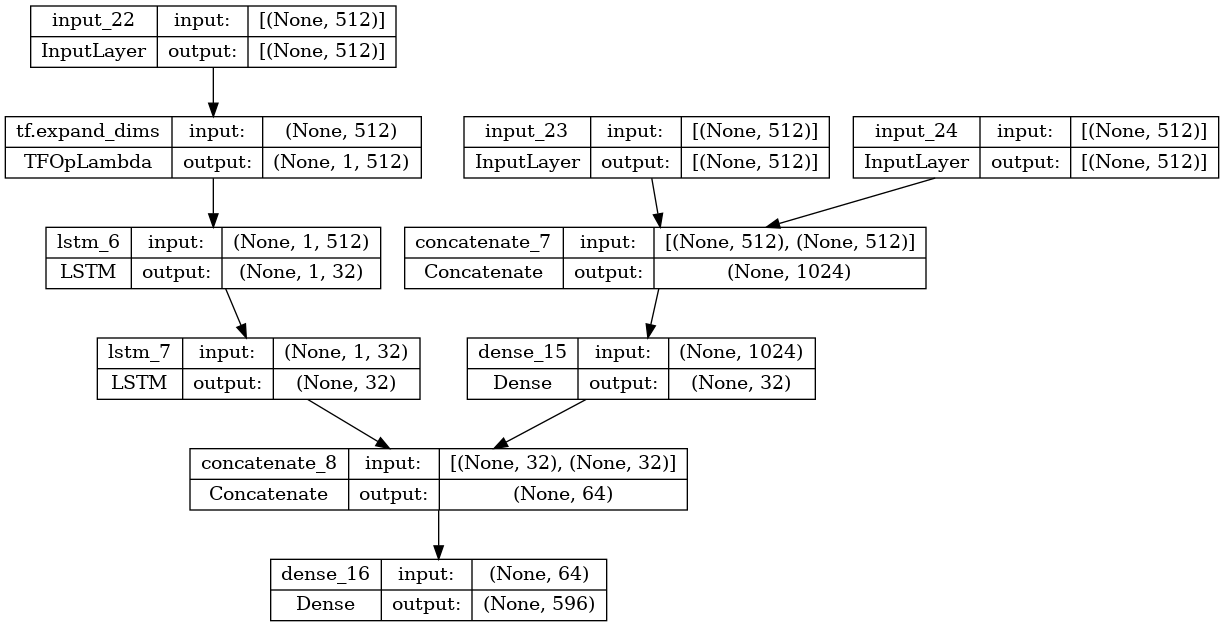

In [ ]:
plot_model(model_5, to_file='model_5.png', show_shapes=True, show_layer_names=True)

Model_6

In [ ]:
input_text = Input(shape=(512,))
input_links = Input(shape=(512,))
input_titles = Input(shape=(512,))
expanded_text_input = tf.expand_dims(input_text, axis=1)
expanded_links_input = tf.expand_dims(input_links, axis=1)
expanded_titles_input = tf.expand_dims(input_titles, axis=1)
texts=GRU(256,return_sequences=True)(expanded_text_input)
links=GRU(512,return_sequences=True)(expanded_links_input)
titles=GRU(256,return_sequences=True)(expanded_titles_input)
texts=GRU(256,return_sequences=True)(texts)
links=GRU(512,return_sequences=True)(links)
titles=GRU(256,return_sequences=True)(titles)
texts = GRU(256,return_sequences=True)(texts)
concatenated = Concatenate()([texts, links,titles])
flattened = Flatten()(concatenated)
output = Dense(units=len(y.value_counts()), activation='softmax')(flattened)
model_6 =Model(inputs=[input_text, input_links, input_titles], outputs=output)
model_6.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_6.fit(x=[tensor_text, tensor_links, tensor_titles], epochs=10, y=y_one_hot,validation_data=([tensor_textt, tensor_linkst, tensor_titlest],y_test_hot), batch_size=32, validation_split=0.2)
predictions=np.array(model_6.predict([tensor_textt,tensor_linkst,tensor_titlest]))
index = int(tf.argmax(predictions[-6]).numpy())
label_encoder.inverse_transform(np.array([index])),np.array(y)[-6]

Epoch 1/10


2023-04-16 22:15:49.707132: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2023-04-16 22:15:49.813027: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2023-04-16 22:15:49.884207: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-addr

76/76 [==============================] - 8s 35ms/step - loss: 6.1301 - accuracy: 0.0351 - val_loss: 5.7247 - val_accuracy: 0.0370
Epoch 2/10
76/76 [==============================] - 2s 22ms/step - loss: 4.9781 - accuracy: 0.1093 - val_loss: 4.8101 - val_accuracy: 0.1630
Epoch 3/10
76/76 [==============================] - 2s 21ms/step - loss: 3.7024 - accuracy: 0.2590 - val_loss: 4.0239 - val_accuracy: 0.2778
Epoch 4/10
76/76 [==============================] - 2s 22ms/step - loss: 2.5212 - accuracy: 0.4359 - val_loss: 3.8428 - val_accuracy: 0.2963
Epoch 5/10
76/76 [==============================] - 2s 21ms/step - loss: 1.5660 - accuracy: 0.6293 - val_loss: 3.8181 - val_accuracy: 0.3667
Epoch 6/10
76/76 [==============================] - 2s 21ms/step - loss: 0.8313 - accuracy: 0.8227 - val_loss: 3.8382 - val_accuracy: 0.3852
Epoch 7/10
76/76 [==============================] - 2s 21ms/step - loss: 0.4171 - accuracy: 0.9196 - val_loss: 4.1391 - val_accuracy: 0.3593
Epoch 8/10
76/76 [======

(array(['io9'], dtype=object), 'Techsonian \\(press release\\)')

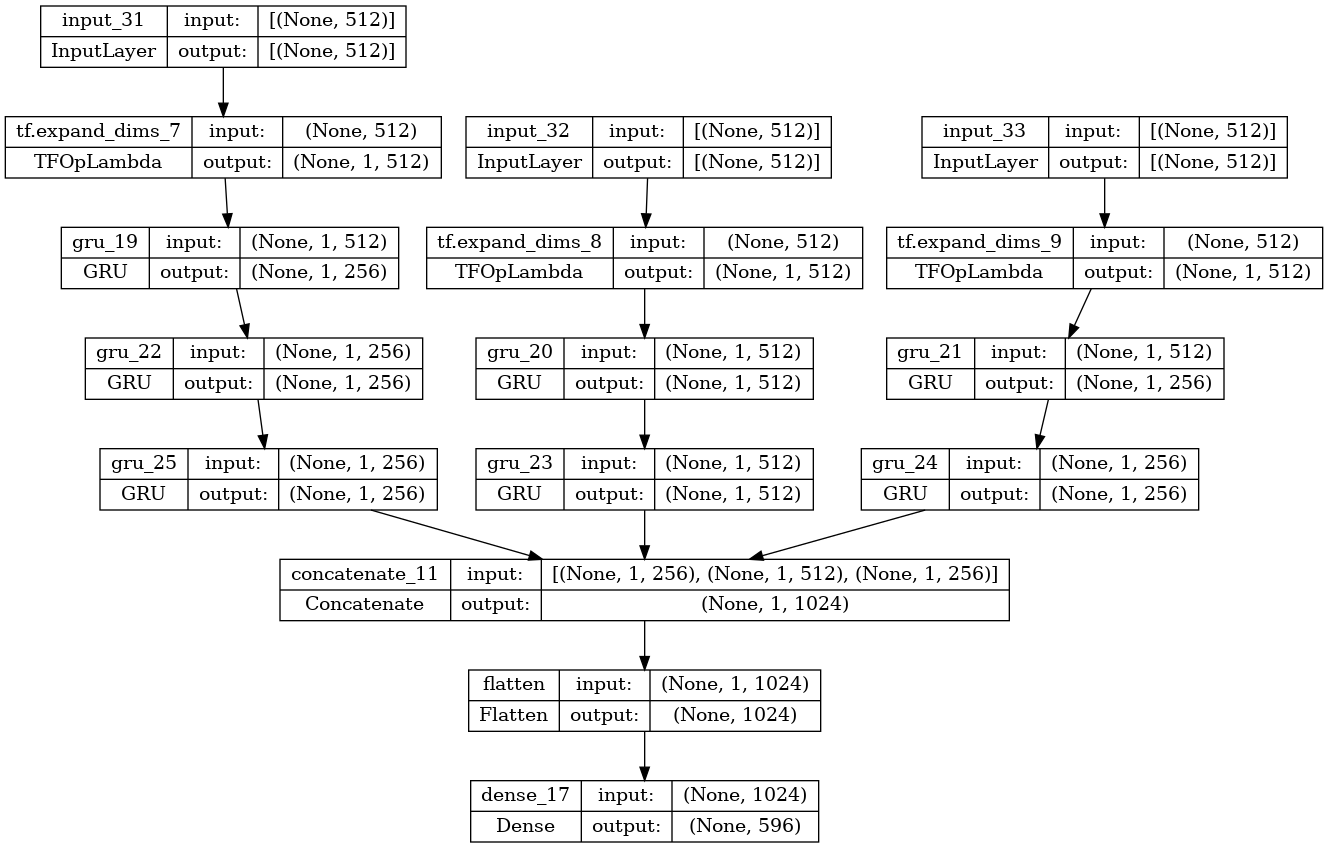

In [ ]:
plot_model(model_6, to_file='model_6.png', show_shapes=True, show_layer_names=True)

Model_7

In [ ]:
input_text = Input(shape=(512,))
input_links = Input(shape=(512,))
input_titles = Input(shape=(512,))
expanded_text_input = tf.expand_dims(input_text, axis=1)
expanded_links_input = tf.expand_dims(input_links, axis=1)
expanded_titles_input = tf.expand_dims(input_titles, axis=1)
texts=GRU(256,return_sequences=True)(expanded_text_input)
links=GRU(512,return_sequences=True)(expanded_links_input)
titles=GRU(256,return_sequences=True)(expanded_titles_input)
texts=GRU(512,return_sequences=True)(texts)
links=GRU(512,return_sequences=True)(links)
titles=GRU(512,return_sequences=True)(titles)
added_text = Add()([input_text, texts])
added_links = Add()([input_links, links])
added_titles = Add()([input_titles, titles])
texts=Dense(256,activation='relu')(added_text)
texts=Dropout(0.8)(texts)
links=Dense(256,activation='relu')(added_links)
links=Dropout(0.8)(links)
titles=Dense(256,activation='relu')(added_titles)
titles=Dropout(0.8)(titles)
texts=GRU(256,return_sequences=True)(added_text)
links=GRU(512,return_sequences=True)(added_links)
titles=GRU(256,return_sequences=True)(added_titles)
concatenated = Concatenate()([texts, links,titles])
flattened = Flatten()(concatenated)
flattened=Dropout(0.8)(flattened)
output = Dense(units=len(y.value_counts()), activation='softmax')(flattened)
model_7 =Model(inputs=[input_text, input_links, input_titles], outputs=output)
model_7.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_7.fit(x=[tensor_text, tensor_links, tensor_titles], epochs=15, y=y_one_hot,validation_data=([tensor_textt, tensor_linkst, tensor_titlest],y_test_hot), batch_size=32, validation_split=0.2)
predictions=np.array(model_7.predict([tensor_textt,tensor_linkst,tensor_titlest]))
index = int(tf.argmax(predictions[-6]).numpy())
label_encoder.inverse_transform(np.array([index])),np.array(y)[-6]

Epoch 1/15
76/76 [==============================] - 11s 44ms/step - loss: 6.2155 - accuracy: 0.0301 - val_loss: 6.0614 - val_accuracy: 0.0185
Epoch 2/15
76/76 [==============================] - 2s 27ms/step - loss: 5.5961 - accuracy: 0.0726 - val_loss: 5.5360 - val_accuracy: 0.0704
Epoch 3/15
76/76 [==============================] - 2s 26ms/step - loss: 5.0876 - accuracy: 0.1241 - val_loss: 5.1565 - val_accuracy: 0.1407
Epoch 4/15
76/76 [==============================] - 2s 25ms/step - loss: 4.5743 - accuracy: 0.1880 - val_loss: 4.7996 - val_accuracy: 0.2259
Epoch 5/15
76/76 [==============================] - 2s 25ms/step - loss: 4.0755 - accuracy: 0.2524 - val_loss: 4.4421 - val_accuracy: 0.2704
Epoch 6/15
76/76 [==============================] - 2s 26ms/step - loss: 3.6269 - accuracy: 0.3113 - val_loss: 4.1689 - val_accuracy: 0.2963
Epoch 7/15
76/76 [==============================] - 2s 25ms/step - loss: 3.1813 - accuracy: 0.3645 - val_loss: 3.9564 - val_accuracy: 0.3074
Epoch 8/15
7

(array(['The Star-Ledger'], dtype=object), 'Techsonian \\(press release\\)')

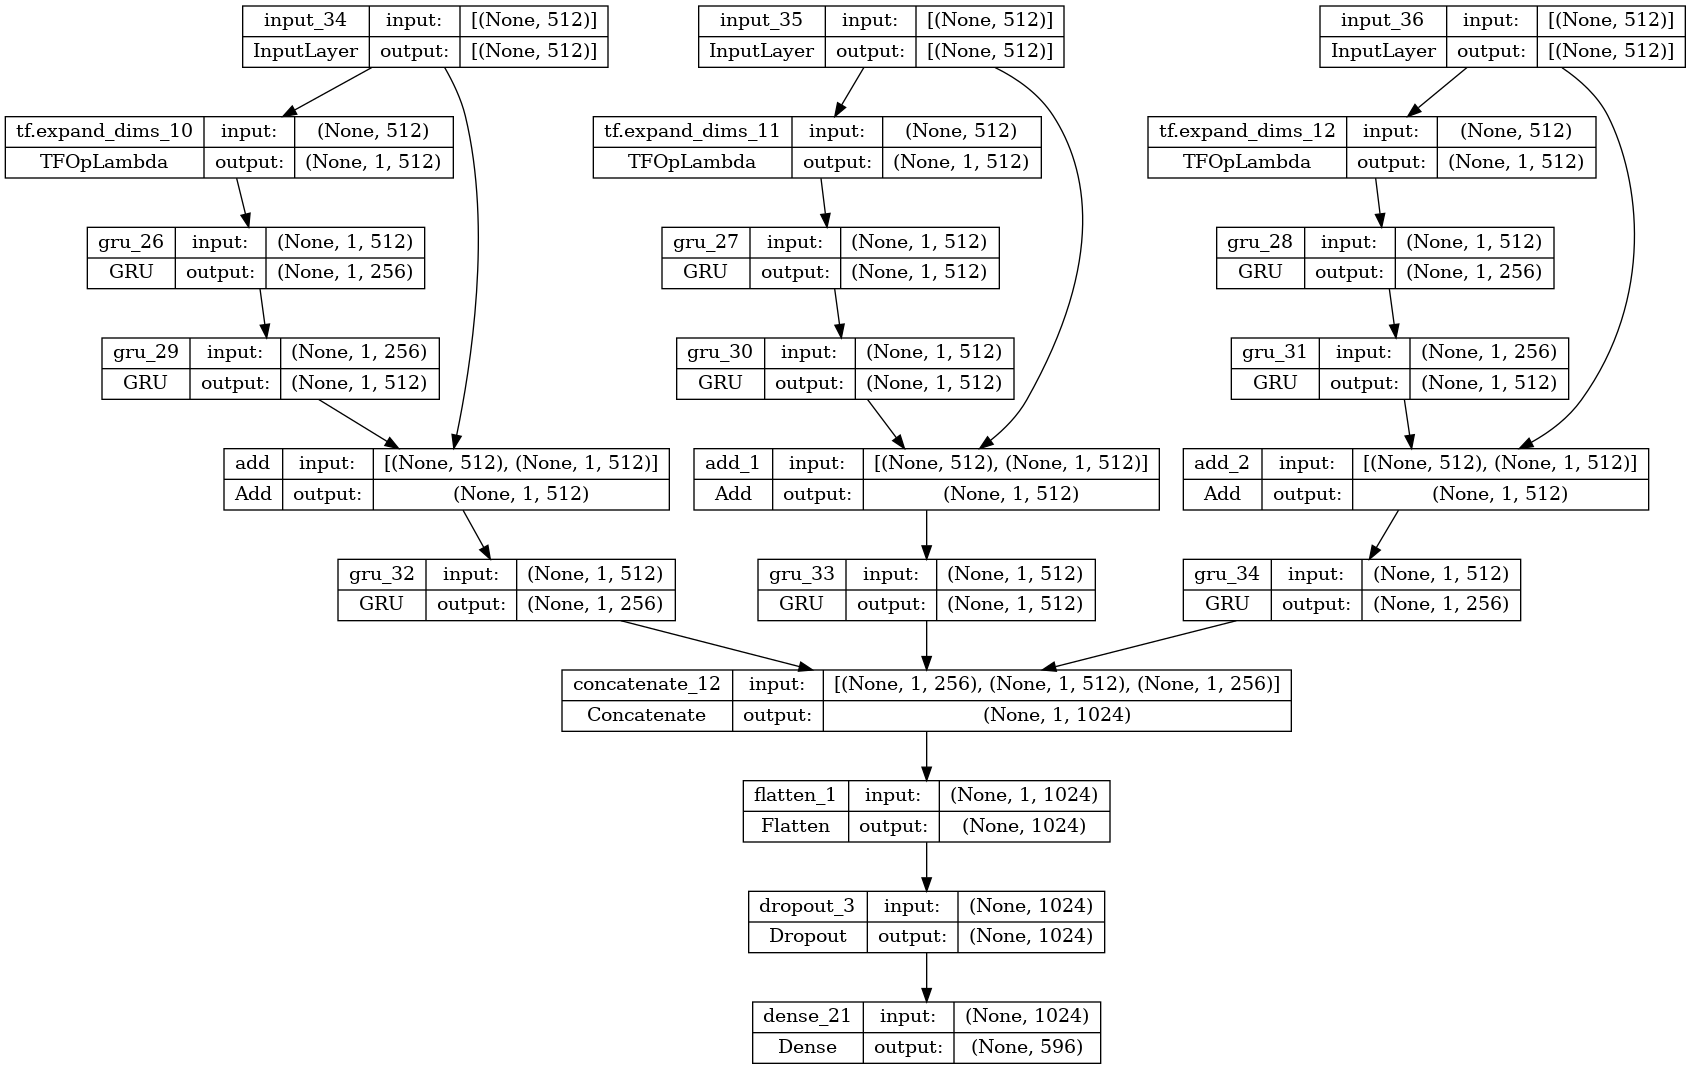

In [ ]:
plot_model(model_7, to_file='model_7.png', show_shapes=True, show_layer_names=True)

In [16]:
import tensorflow
from transformers import TFBertModel
from transformers import BertTokenizer, TFTrainer, TFTrainingArguments

2023-04-25 02:04:29.058736: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
X_train_combined = X_train["Titles"] + " " + X_train["Links"] + " " + X_train["Text"]
X_test_combined = X_test["Titles"] + " " + X_test["Links"] + " " + X_test["Text"]
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
max_length = 128

In [18]:
X_train_tokenized = tokenizer(X_train_combined.tolist(), padding=True, truncation=True, max_length=max_length, return_tensors="np")
X_test_tokenized = tokenizer(X_test_combined.tolist(), padding=True, truncation=True, max_length=max_length, return_tensors="np")

In [20]:
len(X_test_tokenized)

3

Bert_1

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_tokenized["input_ids"], y_one_hot))
train_dataset = train_dataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)


In [ ]:
input_layer = Input(shape=(max_length,), dtype=tf.int32, name="input_layer")

bert = TFBertModel.from_pretrained("bert-base-uncased")

for layer in bert.layers:
    layer.trainable = False

#bert.layers[-1].trainable = True


bert_output = bert(input_layer)[0]

dense_layer = Dense(256, activation="relu")(bert_output[:, 0, :])  # Use the first token's output as the sequence representation
output_layer = Dense(len(y.value_counts()), activation="softmax")(dense_layer)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
#model.fit(x=train_dataset, y=y_one_hot, epochs=5, batch_size=16)

Epoch 1/5


2023-04-18 19:37:16.823052: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x65f5e070 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-04-18 19:37:16.823089: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 3070, Compute Capability 8.6
2023-04-18 19:37:16.826879: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


: 

: 

In [ ]:
predictions = np.array(model.predict(X_test_tokenized["input_ids"]))
predicted_indices = np.argmax(predictions, axis=1)
predicted_labels = label_encoder.inverse_transform(predicted_indices)
s=pd.DataFrame({'Id':range(1,689),'Publisher':predicted_labels}).set_index('Id')
s,s.to_csv('Answer.csv')

22/22 [==============================] - 4s 124ms/step


Bert_2

In [ ]:
bert.layers[::]

In [ ]:
input_layer = Input(shape=(max_length,), dtype=tf.int32, name="input_layer")

bert = TFBertModel.from_pretrained("bert-base-uncased")

for layer in bert.layers:
    layer.trainable = False

bert_output = bert(input_layer)[0]

dense_layer = Dense(256, activation="relu")(bert_output[:, 0, :])  # Use the first token's output as the sequence representation
output_layer = Dense(len(y.value_counts()), activation="softmax")(dense_layer)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

model.fit(x=X_train_tokenized["input_ids"], y=y_one_hot, epochs=5, batch_size=16)


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/5
 32/169 [====>.........................] - ETA: 17s - loss: 6.2935 - accuracy: 0.0176

KeyboardInterrupt: 